In [1]:
import torch
from torch import nn
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0

In [3]:
def process_img(x):
    x = tfs.ToTensor()(x)
    x = (x - 0.5) / 0.5
    return x

In [4]:
train_set = MNIST('./mnist', train = True, download = True, transform = process_img)

In [5]:
x = [1, 32654, 14561, 22325, 9894, 54894, 13894, 22894, 12654, 46894, 0, 37894, 16894, 22387, 11894, 
    28956, 17894, 28959, 42654, 47894]

In [6]:
train_labeled = []

In [7]:
for i in x:
    img = train_set[i]
    img = list(img)
    train_labeled.append(img)

In [8]:
NOISE_DIM = 96
class generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM):
        super(generator, self).__init__()
        self.fc = nn.Sequential(
                    nn.Linear(noise_dim, 1024),
                    nn.ReLU(True),
                    nn.Linear(1024, 1024),
                    nn.ReLU(True),
                    nn.Linear(1024, 7 * 7 * 128),
                    nn.ReLU(True))
        
        self.conv = nn.Sequential(
                    nn.ConvTranspose2d(128, 64, 4, 2, padding = 1),
                    nn.ReLU(True),
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64, 1, 4, 2, padding = 1),
                    nn.Tanh())
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv(x)
        return x

In [9]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Sequential(
                    nn.Linear(1024, 800),
                    nn.ReLU(True),
                    nn.Linear(800, 200),
                    nn.ReLU(True),
                    nn.Linear(200, 11))
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [10]:
bce_loss = nn.BCEWithLogitsLoss()

def generator_loss(logits_fake):
    size = logits_fake.shape[0]
    true_labels = torch.ones(size, 1).float().cuda()
    loss = bce_loss(logits_fake[:,10].view(20, 1), true_labels)
    return loss

In [11]:
def discriminator_loss(labeled, real_label, logits_real, logits_fake):
    size = logits_real.shape[0]
    true_labels = torch.ones(size, 1)
    true_labels = true_labels.float().cuda()
    false_labels = torch.zeros(size, 1)
    false_labels = false_labels.float().cuda()
    loss1 = nn.CrossEntropyLoss()
    loss11 = loss1(labeled[:,0:10], real_label)
    loss2 = bce_loss(logits_real[:,10].view(20, 1), true_labels) + bce_loss(logits_fake[:,10].view(20, 1), false_labels)
    return loss11 + loss2

In [12]:
def discriminator_loss1(logits_real, logits_fake, label):
    size = logits_real.shape[0]
    true_labels = torch.ones(size, 1)
    ture_labels = true_labels.float()
    false_labels = torch.zeros(size, 1)
    false_labels = false_labels.float()
    loss1 = nn.CrossEntropyLoss()
    loss11 = loss1(logits_real[:, 0:10], label)
    loss2 = bce_loss(logits_real[:,10].view(20, 1), true_labels) + bce_loss(logits_fake[:,10].view(20, 1), false_labels)
    return loss11 + loss2

In [13]:
train_labeled_data = DataLoader(train_labeled, batch_size = 20,shuffle = True)

In [14]:
train_unlabeled_data = DataLoader(train_set, batch_size = 20, shuffle = True)

In [15]:
test_set = MNIST('./mnist', train = False, transform = process_img)
test_data = DataLoader(test_set, batch_size = 64, shuffle = False)

In [16]:
G_net = generator().cuda()
D_net = discriminator().cuda()
generator_optim = torch.optim.Adam(G_net.parameters(), lr = 1e-4, betas = (0.5, 0.999))
discriminator_optim = torch.optim.Adam(D_net.parameters(), lr = 1e-4, betas = (0.5, 0.999))

In [17]:
def train_gan(discriminator, generator, discriminator_loss, generator_loss, discriminator_optim, generator_optim, 
              noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for im, label in train_labeled_data:
            for x, _ in train_unlabeled_data:
                bs = x.shape[0]
                labeled = 0
                real_label = 0
            
                real_data = x.cuda()
                logits_real = discriminator(real_data)
            
                sample_noise = (torch.rand(bs, noise_size) - 0.5)/ 0.5
                g_fake_seed = sample_noise.cuda()
                fake_image = generator(g_fake_seed)
                logits_fake = discriminator(fake_image)
                        
                im = im.cuda()
                labeled = discriminator(im)
                d_error = discriminator_loss(labeled, label.cuda(), logits_real, logits_fake)
                discriminator_optim.zero_grad()
                d_error.backward(retain_graph = True)
                discriminator_optim.step()
            
                g_fake_seed = sample_noise.cuda()
                fake_image = generator(g_fake_seed)
                g_logits_fake = discriminator(fake_image)
                g_error = generator_loss(g_logits_fake)
                generator_optim.zero_grad()
                g_error.backward()
                generator_optim.step()
        
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_error.data.item(), g_error.data.item()))
        imgs_numpy = deprocess_img(fake_image.data.cpu().numpy())
        show_images(imgs_numpy[0:3])
        plt.show()
        iter_count += 1

Iter: 0, D: 0.08388, G:3.836


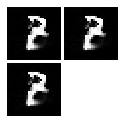

Iter: 1, D: 0.07423, G:3.776


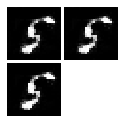

Iter: 2, D: 0.2478, G:3.298


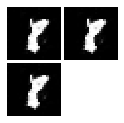

Iter: 3, D: 0.002859, G:6.095


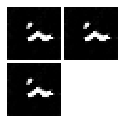

Iter: 4, D: 0.4004, G:5.891


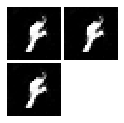

Iter: 5, D: 0.005388, G:5.789


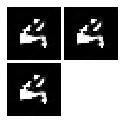

Iter: 6, D: 0.3208, G:4.037


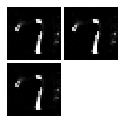

Iter: 7, D: 0.003539, G:6.796


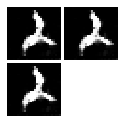

Iter: 8, D: 0.002579, G:6.113


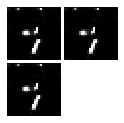

Iter: 9, D: 0.1817, G:3.529


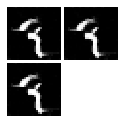

Iter: 10, D: 0.004079, G:5.933


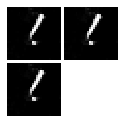

Iter: 11, D: 0.002279, G:6.526


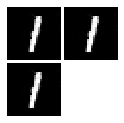

Iter: 12, D: 0.1364, G:4.546


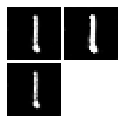

Iter: 13, D: 0.176, G:4.483


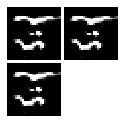

Iter: 14, D: 0.00122, G:6.977


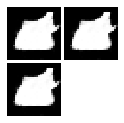

Iter: 15, D: 0.002752, G:6.045


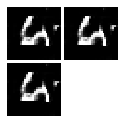

Iter: 16, D: 0.1271, G:4.027


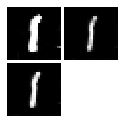

Iter: 17, D: 0.0004005, G:11.32


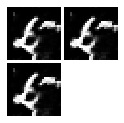

Iter: 18, D: 7.272e-06, G:11.83


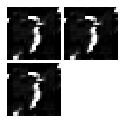

Iter: 19, D: 0.009971, G:5.11


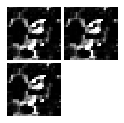

In [18]:
train_gan(D_net, G_net, discriminator_loss, generator_loss, discriminator_optim, generator_optim, num_epochs = 20)

In [19]:
for e in range(3):
    eval_acc = 0
    for im, label in test_data:
        im = im.cuda()
        label = label.cuda()
        out = D_net(im)
        _,pred = out[:,0:10].max(1)
        num_correct = (pred == label).sum().data.item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    print('acc:{:.6f}'.format(eval_acc/len(test_data)))

acc:0.576334
acc:0.576334
acc:0.576334


In [ ]:
torch.save(G_net,'./generator.pth')

In [ ]:
torch.save(D_net, './discriminator.pth')

In [ ]:
torch.load('generator.pth')